In [1]:
#https://notes.quantecon.org/submission/5cc8e7dd4174bb001a39a8ff
import statsmodels as sm
#https://www.statsmodels.org/dev/vector_ar.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.simplefilter('ignore')
from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)

In [2]:
train_df = pd.read_csv('/Users/aashrit/Documents/Masters/MY498/Data/Time Series/twitter_reddit_time_series_copy3.csv')
train_df = train_df.set_index('date')
#train = train.iloc[20:,:]
train_df

,overall_sentiment_score_20d_lag,overall_attention_score_20d_lag,BEIR,interest_rate_1yr_lag,commodities_1yr_lag,UNRATENSA_1yr_lag,UMCSENT_2wk_lag,WM2NS_1yr_lag,gdp_1yr_lag,USDEUR_1yr_lag
date,,,,,,,,,,
01/06/2021,26.4459,3.900597,2.460,0.05,99.875276,11.2,82.9,17915.4,19477.444,1.224100
02/06/2021,51.3641,2.348224,2.440,0.06,99.875276,11.2,82.9,17915.4,19477.444,1.221300
03/06/2021,48.4431,1.156789,2.420,0.06,99.875276,11.2,82.9,17915.4,19477.444,1.212200
04/06/2021,17.4456,0.903695,2.400,0.06,99.875276,11.2,82.9,17915.4,19477.444,1.217300
05/06/2021,28.1433,0.947890,2.400,0.07,99.875276,11.2,82.9,17915.4,19477.444,1.216933
...,...,...,...,...,...,...,...,...,...,...
27/05/2022,-56.0960,2.735565,2.630,0.06,155.100579,5.5,58.4,20235.1,22740.959,1.070900
28/05/2022,-4.0143,1.563207,2.630,0.05,155.100579,5.5,58.4,20235.1,22740.959,1.069733
29/05/2022,1.4806,3.380288,2.630,0.05,155.100579,5.5,58.4,20235.1,22740.959,1.071044


In [3]:
nobs = 31
df_train, df_test = train_df[0:-nobs], train_df[-nobs:]

In [4]:
X_train = df_train.drop(['BEIR'],axis=1)
y_train = df_train['BEIR']
X_test = df_test.drop(['BEIR'],axis=1)
y_test = df_test['BEIR']

In [5]:
def train_test_plot(model, X_train, X_test, name):
    """
    This will plot the actual values of CPI against the one fitted by the model
    We train the model until 2009 and then use it from 2009 onwards on the test features dataset
    """
    fig, ax = plt.subplots(figsize=(12,6))
    colors = sns.color_palette("deep", 8)
    plt.ylim(2.5,3)
    
    yvalues = pd.DataFrame(y_test)
    
    forecasted = list(model.predict(X_test)) # Use the model fit on features data from 2009 onwards
    df_fcast = pd.DataFrame({"date": list(yvalues.index), "BEIR_fcast": forecasted})
    df_fcast = df_fcast.set_index("date")
    
    df = pd.merge(yvalues, df_fcast, left_index=True, right_index=True)

    df["BEIR_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
    df["BEIR"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
    ax.set_title("Forecasted BEIR vs. Actual BEIR")
    ax.set_ylabel("BEIR")

    ax.set_xlabel("Date")
    ax.legend(["Forecasted BEIR","Actual BEIR"])
    plt.savefig(name)

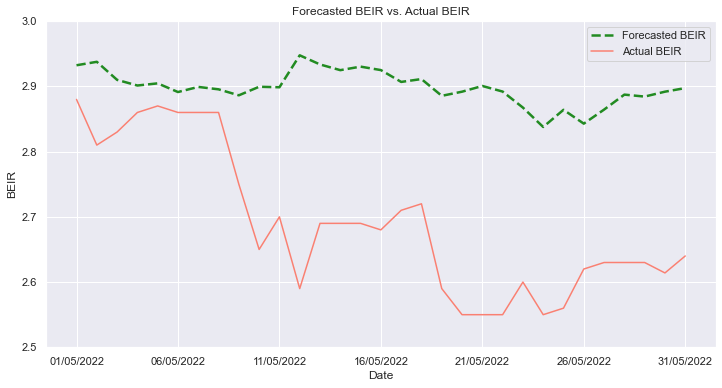

In [6]:
lasso = linear_model.LassoCV(cv=model_selection.TimeSeriesSplit(n_splits=5), 
                             alphas=None, tol = 10000, normalize=True) 

lasso = lasso.fit(X_train, y_train)
optimal_alpha = lasso.alpha_

lasso2 = linear_model.Lasso(alpha=optimal_alpha, normalize=True)
lasso2.fit(X_train, y_train)

train_test_plot(lasso2, X_train, X_test, 'lasso_forecast') 

In [7]:
metrics.mean_squared_error(y_test, lasso2.predict(X_test), squared = False)

0.23123981531520515

In [8]:
df_test.index

Index(['01/05/2022', '02/05/2022', '03/05/2022', '04/05/2022', '05/05/2022',
       '06/05/2022', '07/05/2022', '08/05/2022', '09/05/2022', '10/05/2022',
       '11/05/2022', '12/05/2022', '13/05/2022', '14/05/2022', '15/05/2022',
       '16/05/2022', '17/05/2022', '18/05/2022', '19/05/2022', '20/05/2022',
       '21/05/2022', '22/05/2022', '23/05/2022', '24/05/2022', '25/05/2022',
       '26/05/2022', '27/05/2022', '28/05/2022', '29/05/2022', '30/05/2022',
       '31/05/2022'],
      dtype='object', name='date')

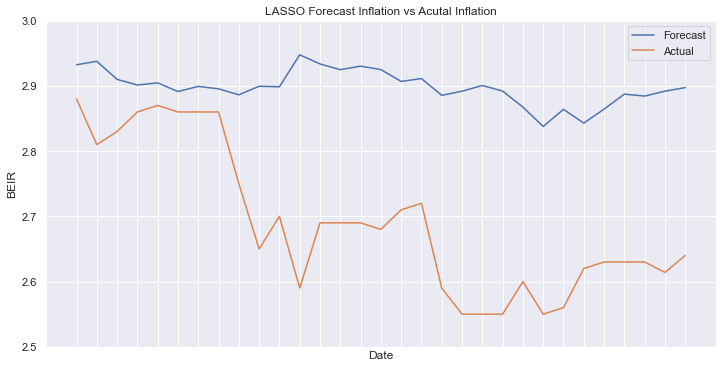

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df_test.index, lasso2.predict(X_test), label = "Forecast")
# plotting the line 2 points 
plt.plot(df_test.index, y_test, label = "Actual")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('BEIR')
# Set a title of the current axes.
plt.title('LASSO Forecast Inflation vs Acutal Inflation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(2.5,3)
# show a legend on the plot
plt.legend()
plt.savefig('lasso_forecast.png')
# Display a figure.
plt.show()

In [10]:
lasso_coefs = pd.DataFrame({"features":list(X_train), "coef": lasso2.coef_})
lasso_coefs = lasso_coefs[lasso_coefs.coef != 0.0]

In [11]:
lasso_coefs.sort_values("coef", ascending=False)

,features,coef
1,overall_attention_score_20d_lag,0.001064
6,WM2NS_1yr_lag,0.000033
0,overall_sentiment_score_20d_lag,-0.000242
4,UNRATENSA_1yr_lag,-0.000358
8,USDEUR_1yr_lag,-2.768270
2,interest_rate_1yr_lag,-3.357524


In [12]:
rmse = metrics.mean_squared_error(y_test, lasso2.predict(X_test), squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (6.6% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.23123981531520515
8.593802329071092


In [13]:
print(max(lasso2.predict(X_test)))
print(min(lasso2.predict(X_test)))

2.947615963593436
2.8377519854604443


### Checking Alpha CV

In [14]:
optimal_alpha

0.0010081119864565641

In [15]:
len(lasso.alphas_)
#Grid from 8.69315254e-06 to 8.69315254e-03
#0.00000869315254 to 0.00869315254

100

In [16]:
lasso.alphas_

array([8.76804395e-03, 8.17710713e-03, 7.62599748e-03, 7.11203077e-03,
       6.63270370e-03, 6.18568167e-03, 5.76878743e-03, 5.37999046e-03,
       5.01739711e-03, 4.67924134e-03, 4.36387613e-03, 4.06976549e-03,
       3.79547692e-03, 3.53967447e-03, 3.30111226e-03, 3.07862834e-03,
       2.87113910e-03, 2.67763393e-03, 2.49717037e-03, 2.32886944e-03,
       2.17191144e-03, 2.02553187e-03, 1.88901780e-03, 1.76170433e-03,
       1.64297135e-03, 1.53224058e-03, 1.42897269e-03, 1.33266472e-03,
       1.24284758e-03, 1.15908381e-03, 1.08096544e-03, 1.00811199e-03,
       9.40168613e-04, 8.76804395e-04, 8.17710713e-04, 7.62599748e-04,
       7.11203077e-04, 6.63270370e-04, 6.18568167e-04, 5.76878743e-04,
       5.37999046e-04, 5.01739711e-04, 4.67924134e-04, 4.36387613e-04,
       4.06976549e-04, 3.79547692e-04, 3.53967447e-04, 3.30111226e-04,
       3.07862834e-04, 2.87113910e-04, 2.67763393e-04, 2.49717037e-04,
       2.32886944e-04, 2.17191144e-04, 2.02553187e-04, 1.88901780e-04,
      

In [17]:
alpha_cvs = [np.mean(i) for i in lasso.mse_path_]
alpha_cvs

[0.05748843463183412,
 0.05748843463183412,
 0.05748843463183412,
 0.05748843463183412,
 0.05748843463183412,
 0.05748843463183412,
 0.05687174877599398,
 0.05642949331769691,
 0.05606691017837727,
 0.055828256768486725,
 0.05557606084626143,
 0.054561957493772385,
 0.05369865663641871,
 0.05296559131236809,
 0.05235911303003125,
 0.051851331088875206,
 0.05142757974872998,
 0.05107548648192613,
 0.05083719318062445,
 0.050703773110426564,
 0.050565057082019194,
 0.05047592999505064,
 0.05042258625470904,
 0.0503987922104404,
 0.050348238906088236,
 0.050204756911476855,
 0.050065450932845076,
 0.05006702530765643,
 0.05009701734554265,
 0.050137868834737254,
 0.049937629558448514,
 0.04987901623884391,
 0.04988773139190182,
 0.049944399216538815,
 0.050038690386594156,
 0.0501625652955414,
 0.05028455841855258,
 0.05042189331670662,
 0.05062431085653457,
 0.05083621218343629,
 0.0510549292904931,
 0.051311349361451944,
 0.051551289369377085,
 0.05186120508852739,
 0.05224023765300547,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


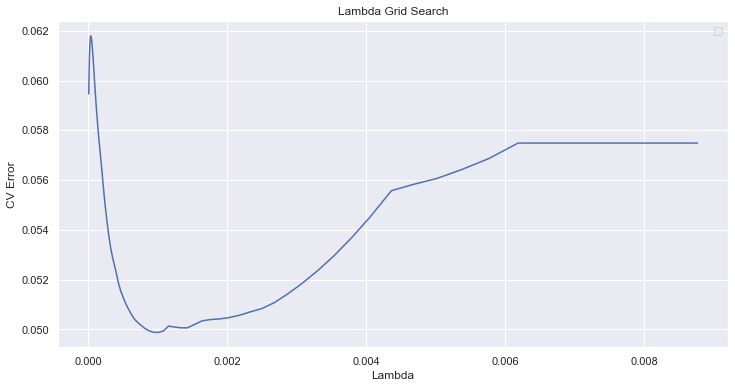

In [18]:
#Plot of cross validation errors
plt.figure(figsize=(12,6))
plt.plot(lasso.alphas_,alpha_cvs)
# plotting the line 2 points 
plt.xlabel('Lambda')
# Set the y axis label of the current axis.
plt.ylabel('CV Error')
# Set a title of the current axes.
plt.title('Lambda Grid Search')
# show a legend on the plot
plt.legend()
plt.savefig('lambda_search.png')
# Display a figure.
plt.show()

In [19]:
#https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/#lasso-regression

In [20]:
print('R squared training set', round(lasso2.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso2.score(X_test, y_test)*100, 2))

R squared training set 67.98
R squared test set -345.41


In [21]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = lasso2.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = lasso2.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 0.01
MSE test set 0.05


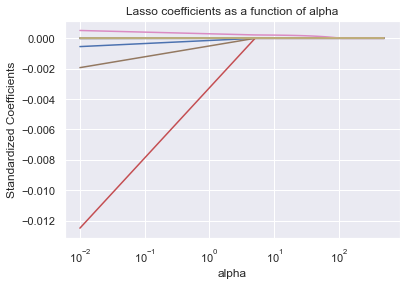

In [22]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = linear_model.Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [23]:
print(list(zip(lasso2.coef_, train_df)))

[(-0.00024173973391033638, 'overall_sentiment_score_20d_lag'), (0.0010643995032415853, 'overall_attention_score_20d_lag'), (-3.3575241305814907, 'BEIR'), (0.0, 'interest_rate_1yr_lag'), (-0.00035777283080796357, 'commodities_1yr_lag'), (-0.0, 'UNRATENSA_1yr_lag'), (3.3080634653402865e-05, 'UMCSENT_2wk_lag'), (0.0, 'WM2NS_1yr_lag'), (-2.768269661160361, 'gdp_1yr_lag')]


In [24]:
print('R squared training set', round(lasso2.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso2.score(X_test, y_test)*100, 2))

R squared training set 67.98
R squared test set -345.41


In [25]:
mean_squared_error(y_test, lasso2.predict(X_test))

0.05347185218701019

In [26]:
plt.figure(figsize = (12,6))
plt.semilogx(lasso.alphas_, lasso.mse_path_, ":")
plt.plot(
    lasso.alphas_ ,
    lasso.mse_path_.mean(axis=-1),
    "k",
    label="Average across folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_, linestyle="--", color="k", label="Lambda: CV estimate"
)

plt.legend()
plt.xlabel("Lambdas")
plt.ylabel("Mean Squared Error")
plt.title("Mean Square Error on Each Fold")
plt.axis("tight")
plt.savefig("lasso_alpha.png")


AttributeError: 'Lasso' object has no attribute 'alphas_'

<Figure size 864x432 with 0 Axes>

In [27]:
X_train1 = df_train.drop(['BEIR','overall_sentiment_score_20d_lag','overall_attention_score_20d_lag'],axis=1)
y_train = df_train['BEIR']
X_test1 = df_test.drop(['BEIR','overall_sentiment_score_20d_lag','overall_attention_score_20d_lag'],axis=1)
y_test = df_test['BEIR']

In [28]:
lasso2 = linear_model.Lasso(alpha=optimal_alpha, normalize=True)
lasso2.fit(X_train1, y_train)
y_pred2 = lasso2.predict(X_test1)
rmse = metrics.mean_squared_error(y_test, y_pred2, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (6.6% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.22757760382170736
8.457699808752642


In [31]:
lasso2.fit(X_train, y_train)
y_pred1 = lasso2.predict(X_test)
y_pred1

array([2.93236306, 2.93765   , 2.90997507, 2.90131276, 2.90461176,
       2.89131546, 2.89916028, 2.89546827, 2.88628767, 2.89938226,
       2.898618  , 2.94761596, 2.93362137, 2.92486185, 2.93025579,
       2.92496958, 2.90682385, 2.9112063 , 2.88551352, 2.89184506,
       2.90060836, 2.89203686, 2.86746445, 2.83775199, 2.86406337,
       2.84286506, 2.86439495, 2.88736178, 2.88433804, 2.89185491,
       2.89736997])

In [32]:
y_test = pd.DataFrame(y_test)
y_pred1 = pd.DataFrame(y_pred1)
y_pred2 = pd.DataFrame(y_pred2)
y_test.columns = ['BEIR']
y_pred1.columns = ['BEIR_forecast']
y_pred2.columns = ['BEIR_forecast']

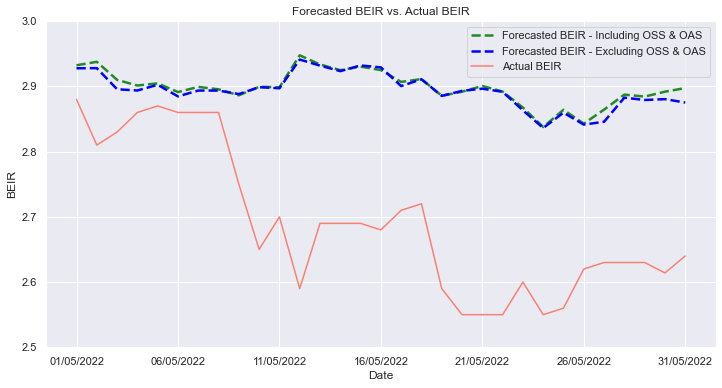

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette("deep", 8)
plt.ylim(2.5,3)
    
yvalues = pd.DataFrame(y_test)
    
y_pred1['BEIR_forecast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
y_pred2['BEIR_forecast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="blue") # CPI fitted
y_test['BEIR'].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
ax.set_title("Forecasted BEIR vs. Actual BEIR")
ax.set_ylabel("BEIR")
ax.set_xlabel("Date")
ax.legend(["Forecasted BEIR - Including OSS & OAS","Forecasted BEIR - Excluding OSS & OAS",'Actual BEIR'])
plt.savefig('lasso_forecast_14-08.png')

In [38]:
y_pred1
y_pred1.to_csv('lasso.csv')